# Some studies about Delta-z effect


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

import invisible_cities.core.fit_functions as fitf

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue Nov 17 12:49:36 2020


### Load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

def append_dfs(dfs):
    df = None
    for i, idf in enumerate(dfs):
        df = idf if i == 0 else df.append(idf, ignore_index = True)
    return df

In [6]:
runs      = [8182, 8183, 8184]
filenames = [get_filename(run) for run in runs]
dds       = [bes.get_df_zeffect(filename) for filename in filenames]
dd        = append_dfs(dds)

In [7]:
dd['S2eq']      = dd['evt_energy']/dd['S2q']
dd['blob1_eta'] = (dd['blob1_z'] - dd['z_min'])/dd['dz_track']
dd['blob2_eta'] = (dd['blob2_z'] - dd['z_min'])/dd['dz_track']

print(len(dd))
print(list(dd.columns))

3204576
['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'S2eq', 'blob1_eta', 'blob2_eta']


In [8]:
ranges                   = bes.get_ranges()
ranges['eblob2.soft']    = (0.2, 1.)
ranges['nS2.one']        = (0.5, 1.5)
ranges['S2e']            = (2.5e5, 1e8)
ranges['enecor.ds.hard'] = (1.630, 1.700)
ranges['enecor.ph.hard'] = (2.600, 2.900)
for key in ranges.keys():
    print(key, ranges[key])

numb_of_tracks.one (0.5, 1.5)
energy (0.0, 3.0)
energy.cs (0.65, 0.71)
energy.ds (1.55, 1.75)
energy.ph (2.5, 3.0)
enecor.cs (0.65, 0.71)
enecor.ds (1.55, 1.75)
enecor.ph (2.5, 3.0)
z_min (50.0, 500.0)
z_max (50.0, 500.0)
r_max (0.0, 180.0)
dz_track.cs (8.0, 32.0)
dz_track.ds (24.0, 72.0)
dz_track.ph (35.0, 130.0)
eblob2.soft (0.2, 1.0)
nS2.one (0.5, 1.5)
S2e (250000.0, 100000000.0)
enecor.ds.hard (1.63, 1.7)
enecor.ph.hard (2.6, 2.9)


In [9]:
selections = bes.Selections(dd, ranges)
selections.logical_and(('z_min', 'z_max', 'r_max', 'energy'), 'fidutial')
print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5],  entries 1742048, efficiency 0.54361
energy : energy [0.0, 3.0],  entries 3204248, efficiency 0.99990
energy.cs : energy [0.65, 0.71],  entries 68703, efficiency 0.02144
energy.ds : energy [1.55, 1.75],  entries 25361, efficiency 0.00791
energy.ph : energy [2.5, 3.0],  entries 1461, efficiency 0.00046
enecor.cs : enecor [0.65, 0.71],  entries 71613, efficiency 0.02235
enecor.ds : enecor [1.55, 1.75],  entries 25678, efficiency 0.00801
enecor.ph : enecor [2.5, 3.0],  entries 2334, efficiency 0.00073
z_min : z_min [50.0, 500.0],  entries 2707418, efficiency 0.84486
z_max : z_max [50.0, 500.0],  entries 2741249, efficiency 0.85542
r_max : r_max [0.0, 180.0],  entries 2400680, efficiency 0.74914
dz_track.cs : dz_track [8.0, 32.0],  entries 1185869, efficiency 0.37005
dz_track.ds : dz_track [24.0, 72.0],  entries 229659, efficiency 0.07167
dz_track.ph : dz_track [35.0, 130.0],  entries 114231, efficiency 0.03565
eblob2.soft : eblob2 [0.2, 1.0]

## Delta-z effect

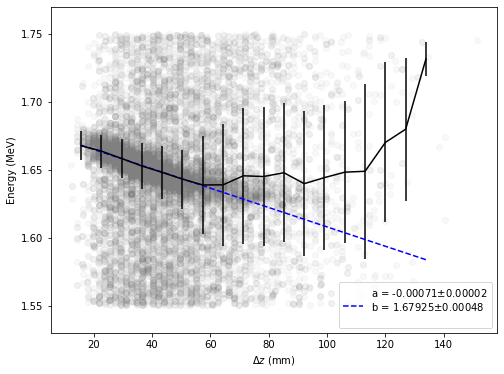

In [10]:
def dz_effect(enes, dz, nsigma = 2.5, xbin = 7):
    plt.scatter(dzs, enes, alpha = 0.05, c='grey');
    xs, ys, eys = pltext.hprofile_in_sigma(dzs, enes, nsigma = 2.5);
    plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)');
    from scipy import optimize
    fun = lambda x, a, b: x * a + b
    par, upar = optimize.curve_fit(fun, xs[:xbin], ys[:xbin], sigma = eys[:xbin])
    upar = np.array([np.sqrt(upar[i, i]) for i in range(2)])
    ss = hfit.str_parameters(par, upar, ('a', 'b'), formate = '6.5f')
    plt.plot(xs, fun(xs, *par), c = 'blue', label = ss, ls = '--');
    plt.legend()

xsel = selections.logical_and(('fidutial', 'energy.ds'))
pltext.canvas(1, 1, 6, 8)
enes, dzs = dd[xsel].energy.values, dd[xsel].dz_track.values
dz_effect(enes, dzs)

**Comments:**

 * There is a strange feature, like a cut on energy, at 50 mm in $\Delta z$. An artifact?
 
 * Effect is around 7.1 keV/cm
 

## Delta-z effect correction

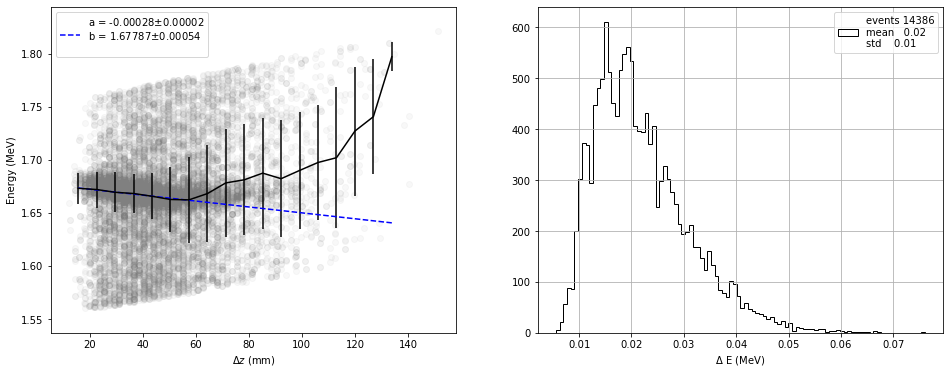

In [11]:
xsel = selections.logical_and(('fidutial', 'energy.ds'))
subplot = pltext.canvas(2, 2, 6, 8)

subplot(1)
enes, dzs = dd[xsel].enecor.values, dd[xsel].dz_track.values
dz_effect(enes, dzs)
plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)');

subplot(2)
denes, dzs = dd[xsel].enecor.values - dd[xsel].energy.values, dd[xsel].dz_track.values
pltext.hist(denes, 100, xylabels = r'$\Delta$ E (MeV)');


## TODO: fit to a straight-line

### $\Delta$ z effect correction of Cs, Tl

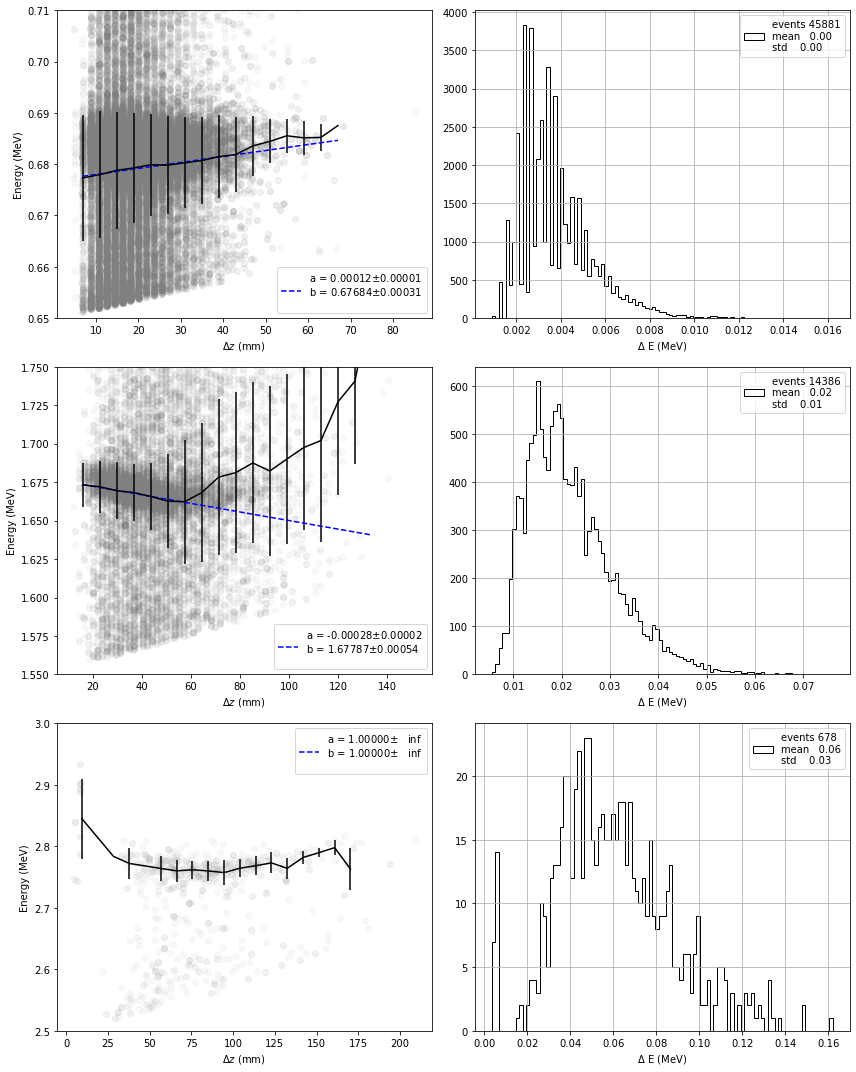

In [12]:
subplot = pltext.canvas(6)

for i, name in enumerate(['cs', 'ds', 'ph']):
    xsel = selections.logical_and(('fidutial', 'energy.'+name))

    subplot(2 * i + 1)
    enes, dzs = dd[xsel].enecor.values, dd[xsel].dz_track.values
    dz_effect(enes, dzs)
    #plt.scatter(dzs, enes, alpha = 0.1, c='grey');
    #xs, ys, eys = pltext.hprofile_in_sigma(dzs, enes, nsigma = 2.5);
    plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)');
    plt.ylim(ranges['energy.'+name])

    subplot(2 * i + 2)
    denes, dzs = dd[xsel].enecor.values - dd[xsel].energy.values, dd[xsel].dz_track.values
    pltext.hist(denes, 100, xylabels = r'$\Delta$ E (MeV)');

plt.tight_layout();

**Comments:**
    
   * It seems that for Cs we over-correct. Average delta correction is 3 keV
    
   * for double scape there is an extra correction with slope -2.8 keV/cm. Average corrections is 20 keV
    
   * It seems that for the photo-peak there is maybe a slightly over-correction at large $\Delta z$. Average correction is 60 keV

## Correlations DS

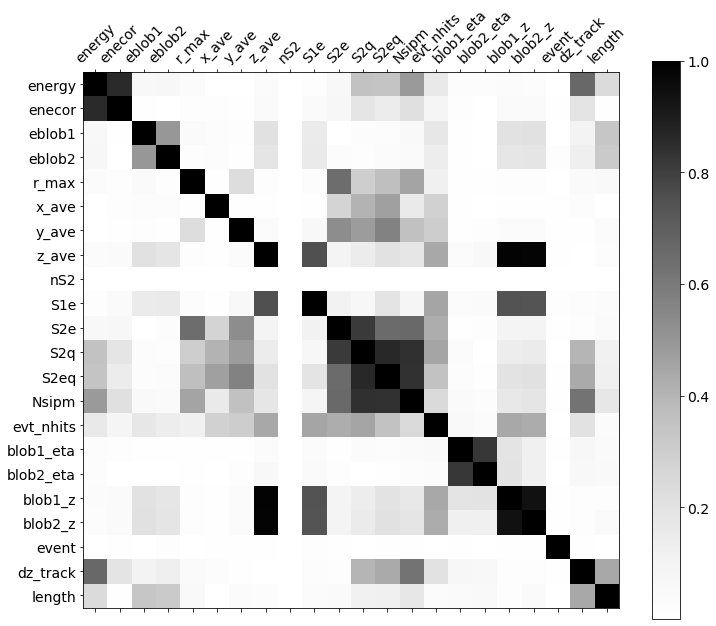

In [13]:
xsel = selections.logical_and(('fidutial', 'enecor.ds.hard', 'eblob2.soft', 'nS2.one'))

labels = ['energy', 'enecor', 'eblob1', 'eblob2', 
          'r_max', 'x_ave', 'y_ave', 'z_ave',
          'nS2', 'S1e', 'S2e', 'S2q', 'S2eq', 'Nsipm', 'evt_nhits',
          'blob1_eta', 'blob2_eta',
          'blob1_z', 'blob2_z', 'event', 'dz_track', 'length']

pltext.corrmatrix(dd[xsel], labels)

**Coments:**

   * energy correlates with number of hits, S2q and $\Delta$z.
   
   * blob energies, S1, S2e, S1q, number of hits are slightly correlated with z (why blob energies?)

### $\Delta$z correlations

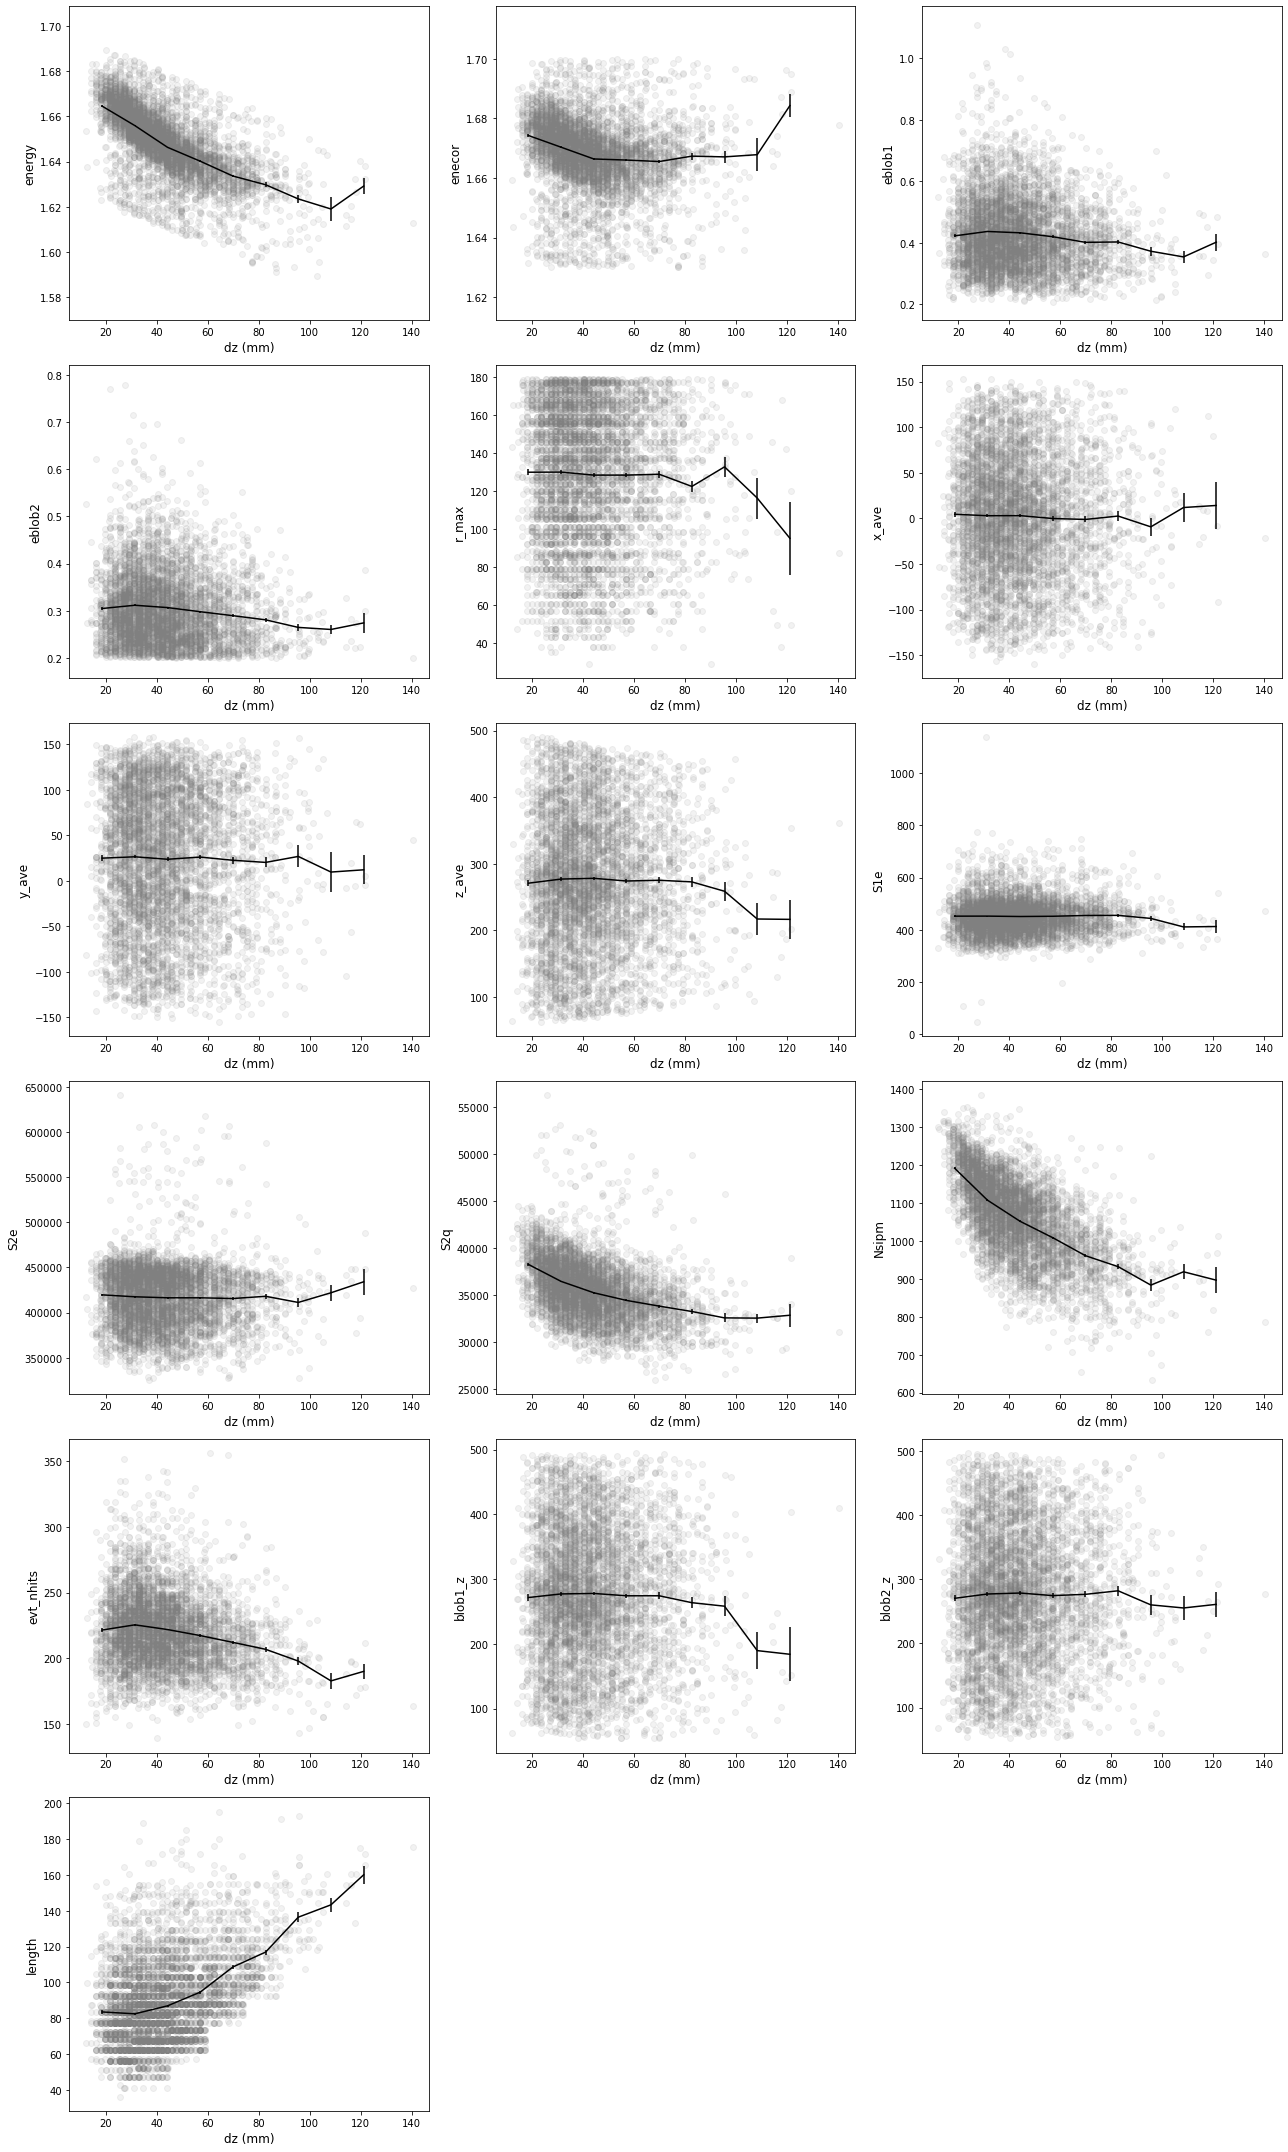

In [14]:
labels = ['energy', 'enecor', 'eblob1', 'eblob2', 
          'r_max', 'x_ave', 'y_ave', 'z_ave',
          'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_nhits',
          'blob1_z', 'blob2_z', 'length']

ranges['S1e'] = (0., 1500)
selections.set_range('S1e', ranges['S1e'])
xsel = selections.logical_and(('fidutial', 'enecor.ds.hard', 'eblob2.soft', 'S2e', 'S1e'))
#xsel = selections.logical_and('fidutial', 'enecor.cs')

subplot = pltext.canvas(len(labels), 3)
for i, label in enumerate(labels):
    subplot(i + 1)
    plt   .scatter(dd[xsel].dz_track, dd[xsel][label], alpha = 0.1, c = 'grey')
    pltext.hprofile(dd[xsel].dz_track, dd[xsel][label])
    plt.xlabel('dz (mm)', fontsize = 12); plt.ylabel(label, fontsize = 12);
plt.tight_layout()

**Comments**:

   * For longer tracks there is less charge and less number of sipms (track maybe horizontal)

### $\Delta$E correlations

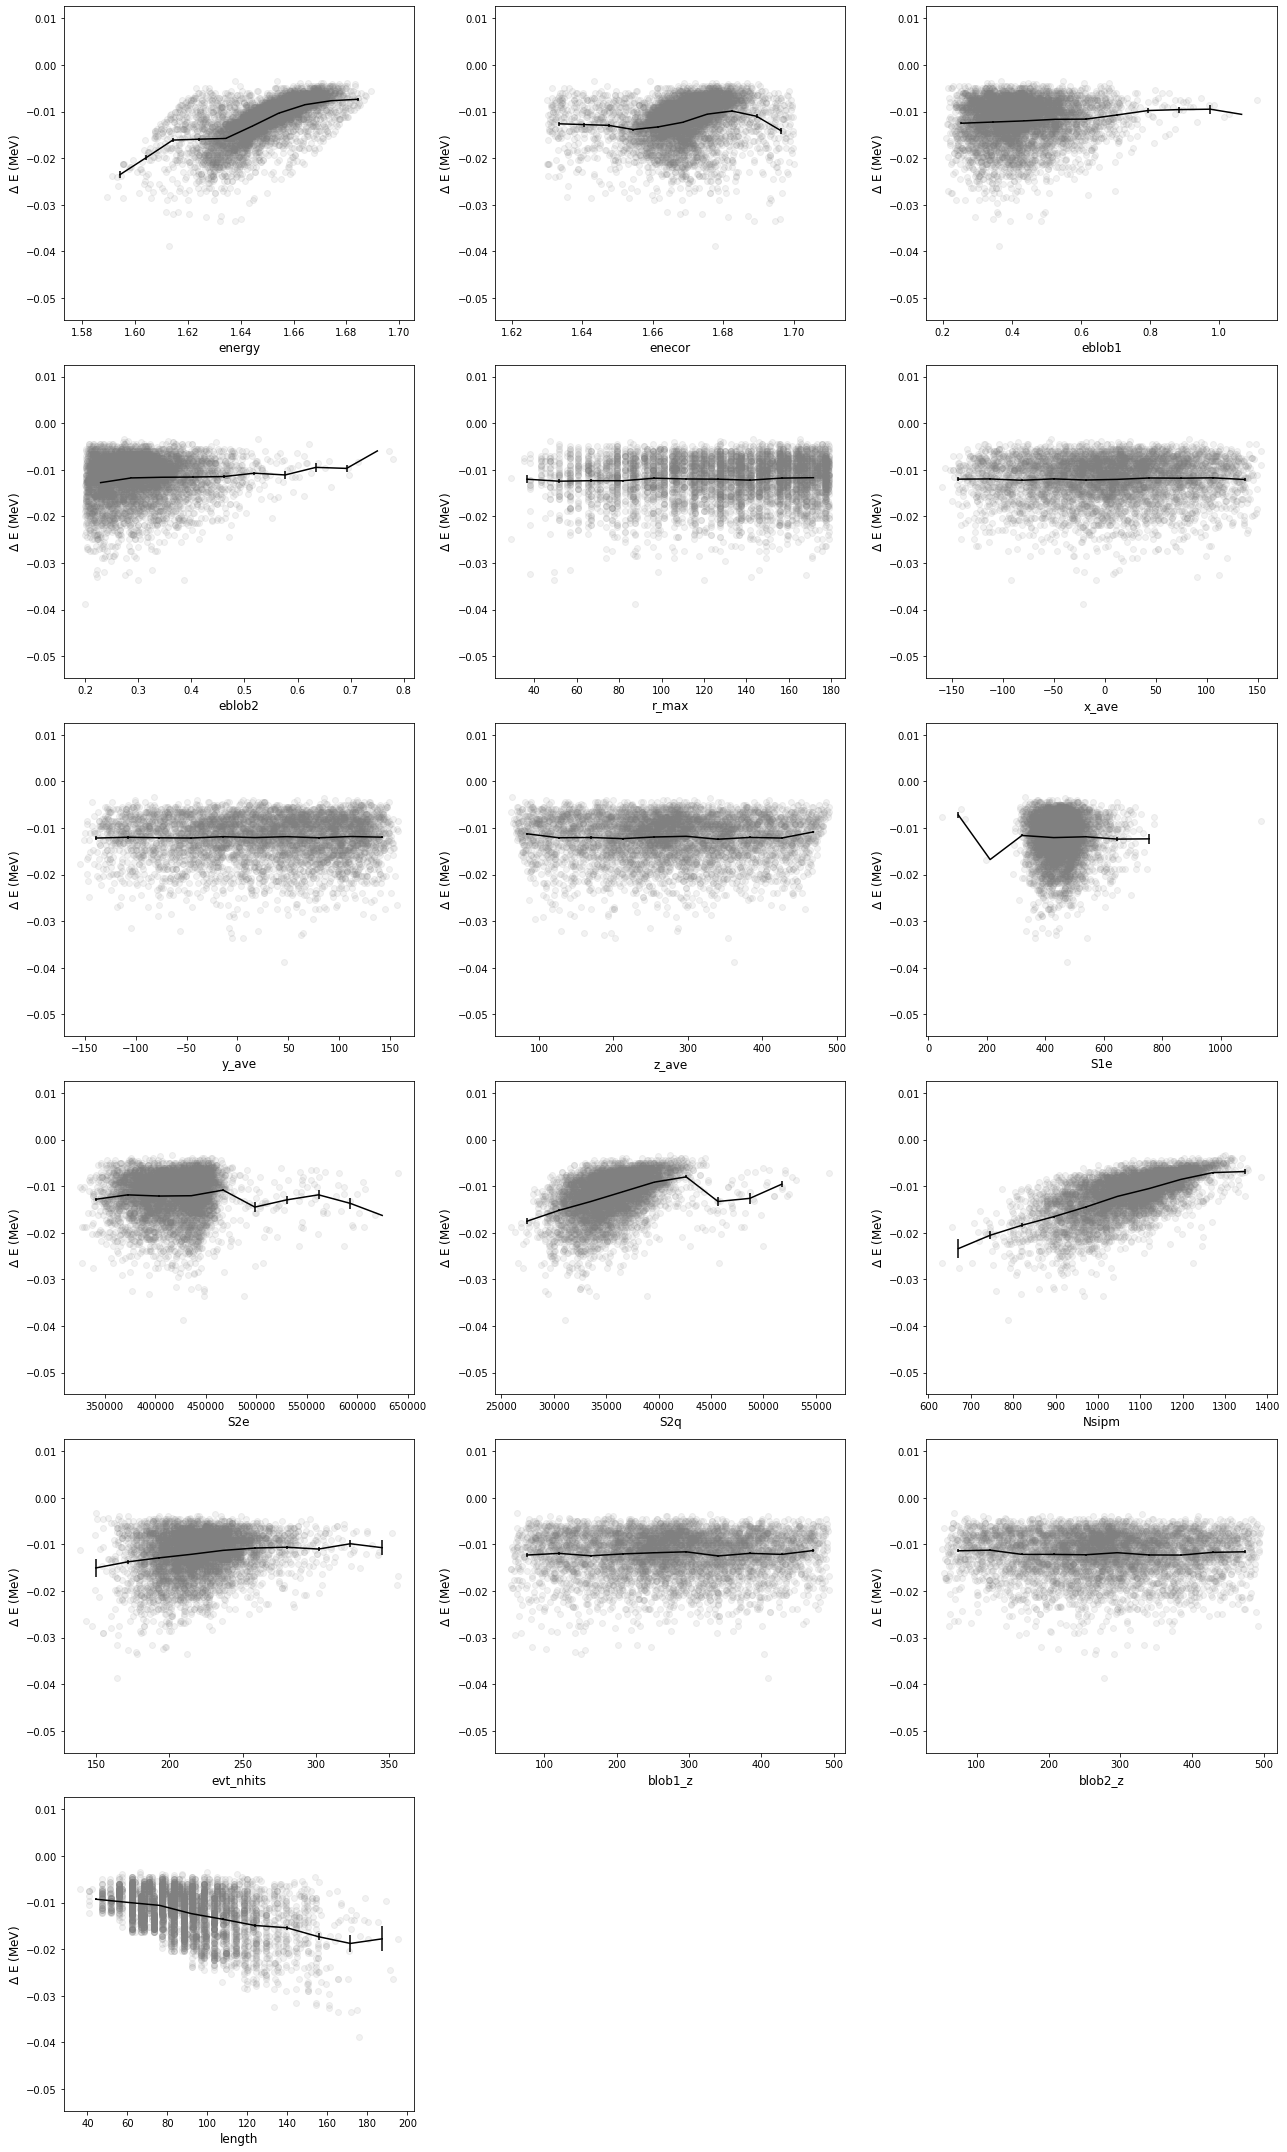

In [15]:
subplot = pltext.canvas(len(labels), 3)
for i, label in enumerate(labels):
    subplot(i + 1)
    x, y = dd[xsel][label], dd[xsel]['energy']/dd[xsel].enecor-1.
    plt   .scatter(x, y, alpha = 0.1, c = 'grey')
    pltext.hprofile(x, y)
    plt.ylabel(r'$\Delta$ E (MeV)', fontsize = 12); plt.xlabel(label, fontsize = 12);
plt.tight_layout()

**Conclusions:**
    
   * No more, again less energy with lower charge and number of hits

### z correlations

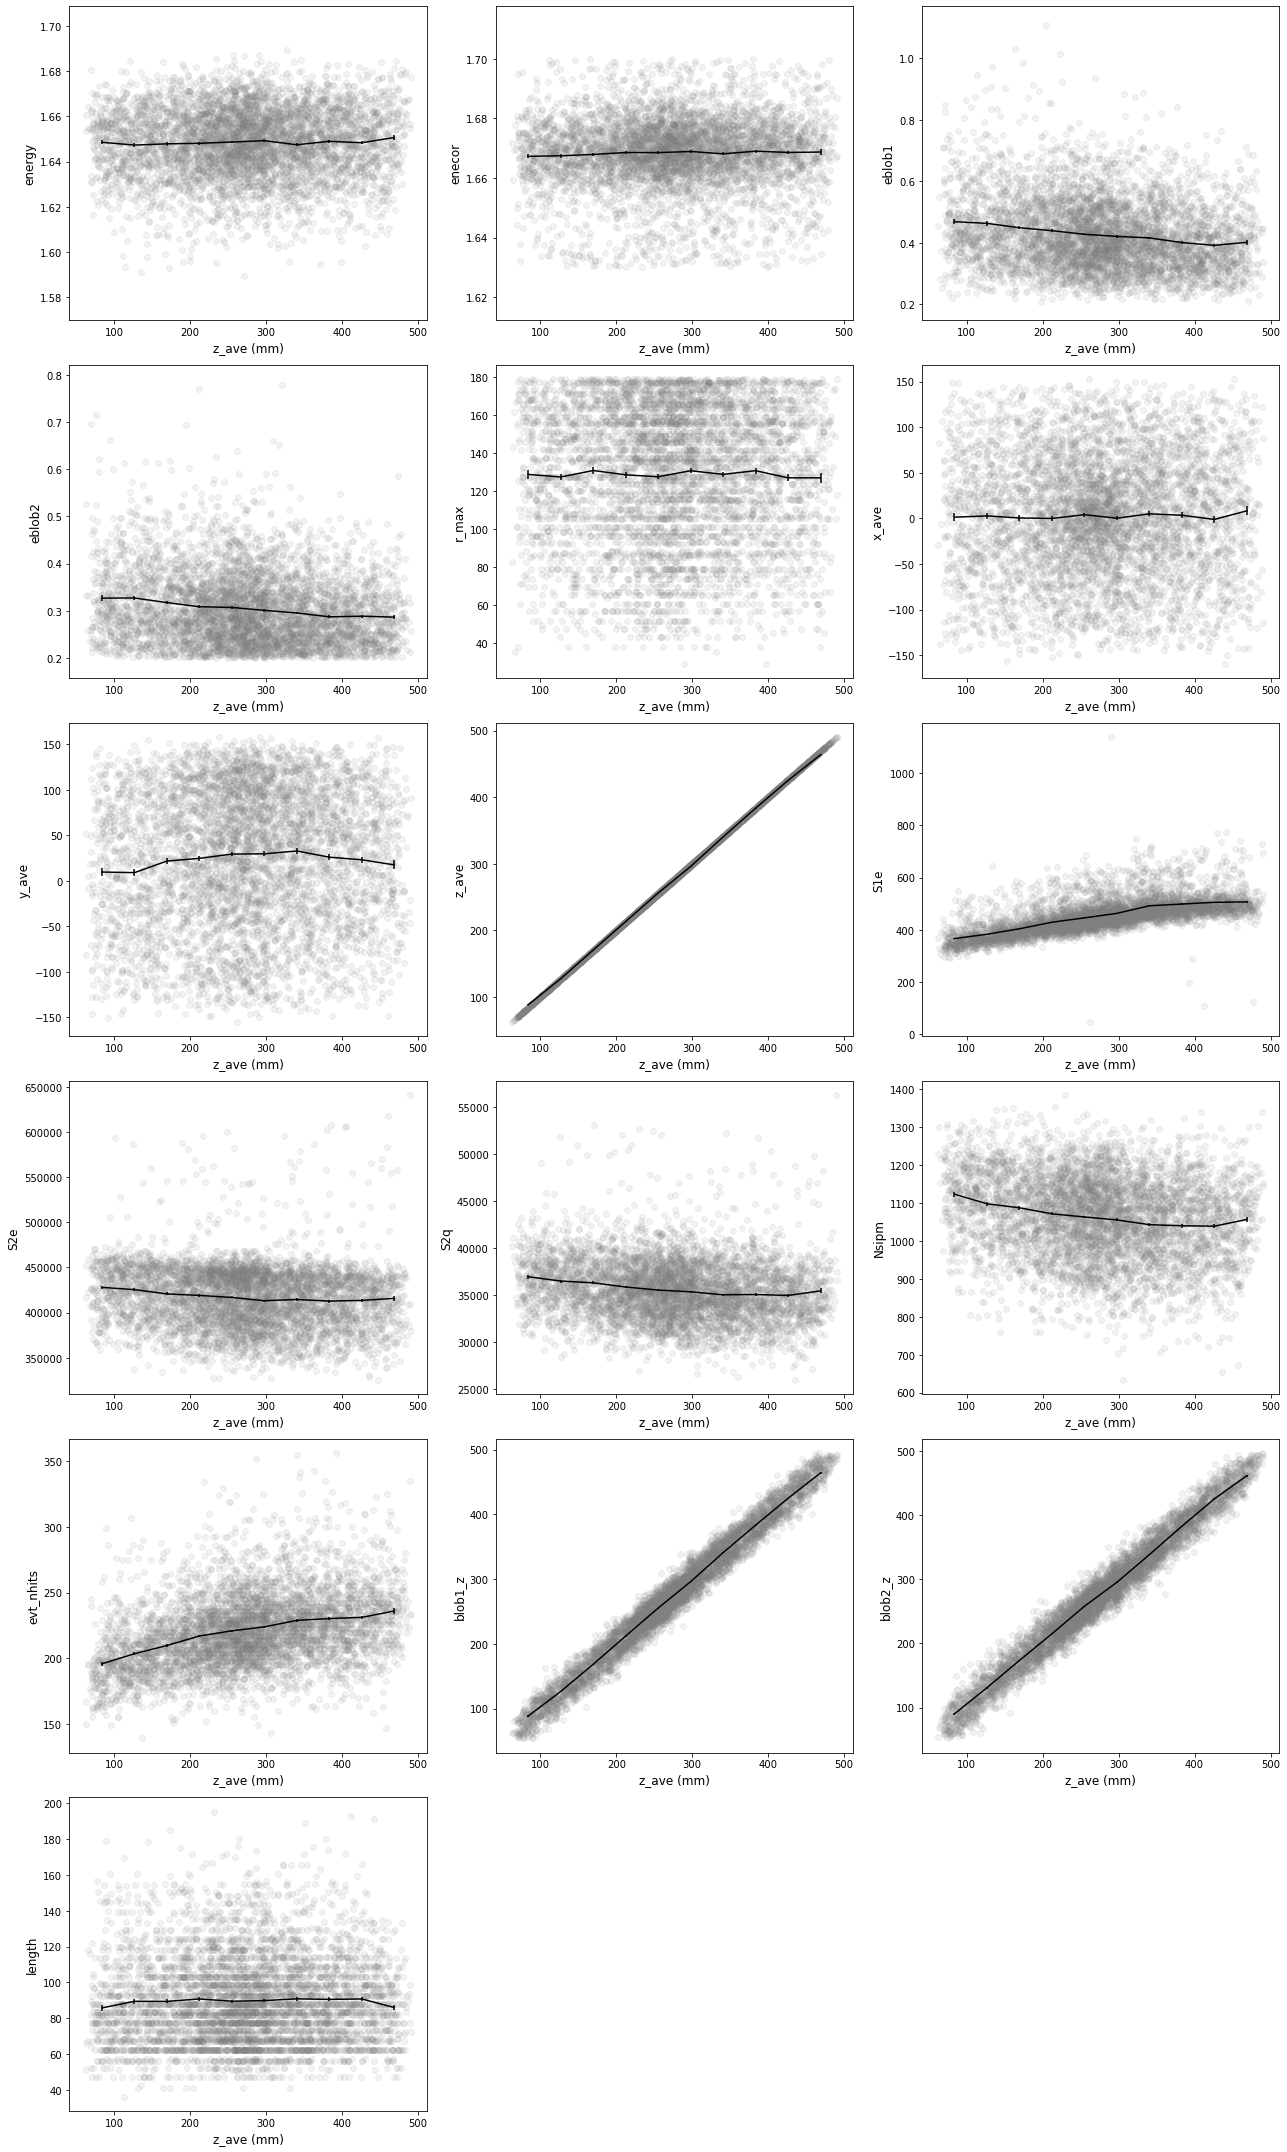

In [16]:
subplot = pltext.canvas(len(labels), 3)
for i, label in enumerate(labels):
    subplot(i + 1)
    y, x = dd[xsel][label], dd[xsel]['z_ave']
    plt   .scatter(x, y, alpha = 0.1, c = 'grey')
    pltext.hprofile(x, y)
    plt.xlabel(r'z_ave (mm)', fontsize = 12); plt.ylabel(label, fontsize = 12);
plt.tight_layout()

**Comments:**

   * Flat dependence with z of the energy and energy correction
   
   * There is a small dependece with the blob energy on z. Most likely due to diffusion and use of the same radius.
   
   * Charge is very similar along $z$, little effect of lifetime, but notice the relevance dependence on $\Delta$z.

### Inspect variables

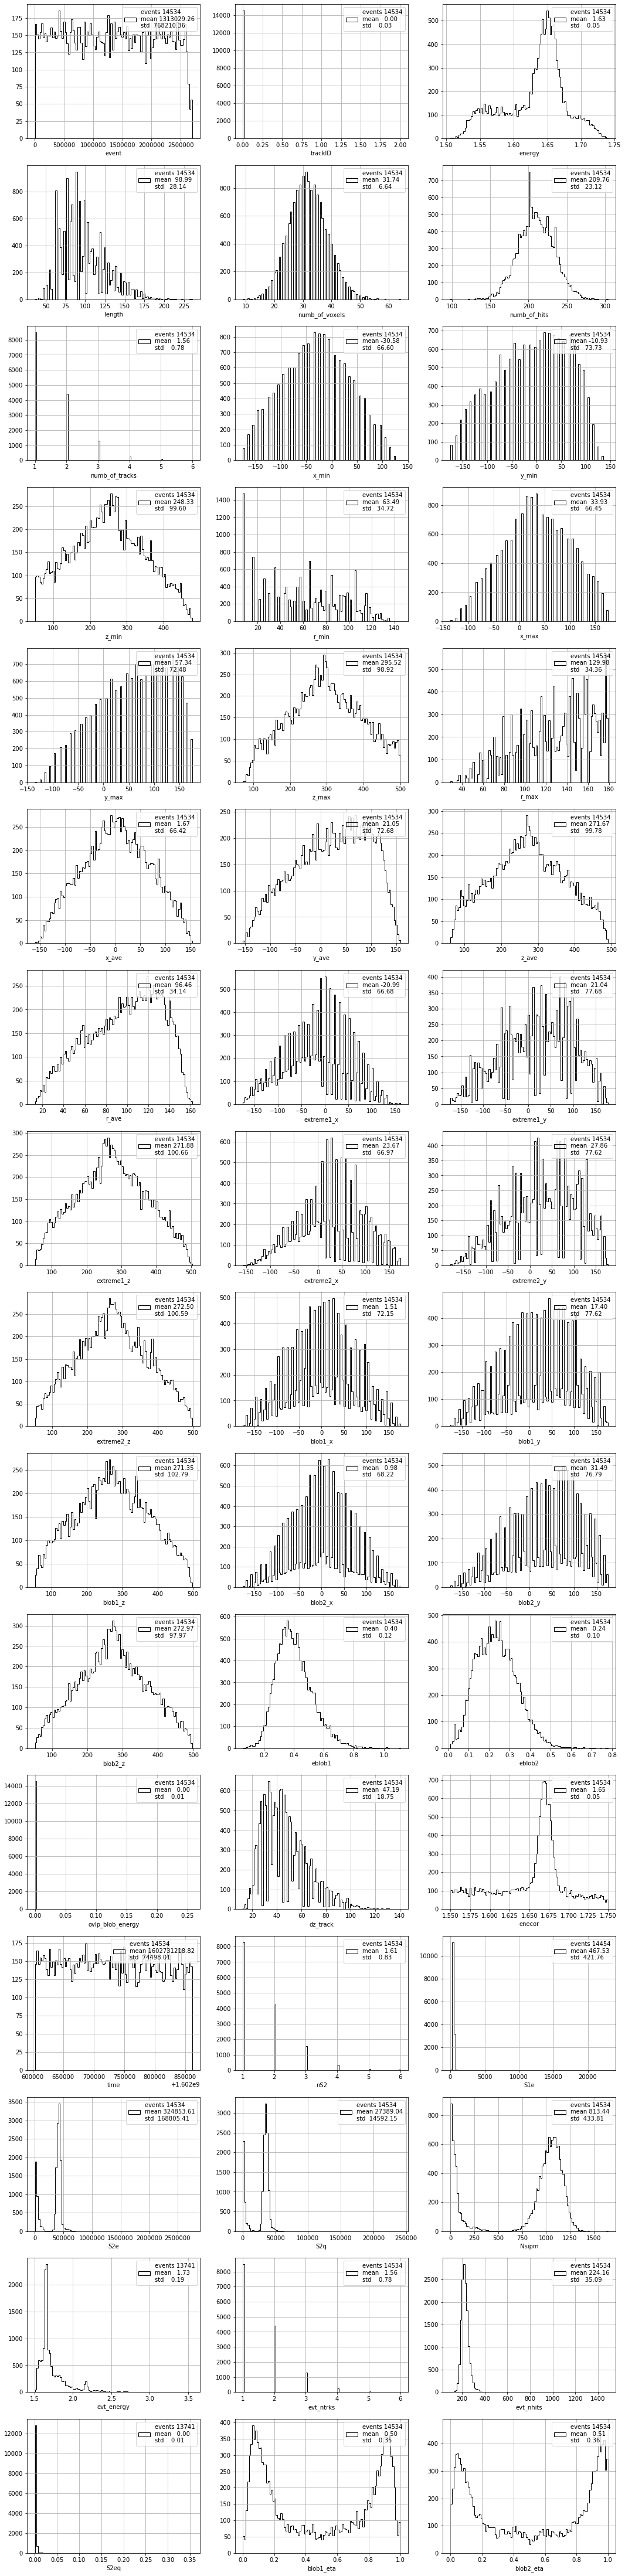

In [17]:
xsel = selections.logical_and(('fidutial', 'enecor.ds'))
pltext.plt_inspect_df(dd[xsel], ncolumns = 3)